# Simple classification with a CNN

**Resource:** https://colab.research.google.com/drive/1pMcNYctQpRoBKD5Z0iXeFWQD8hIDgzCV

In [1]:
# # WandB – Install the W&B library
# !pip install wandb -q
#!pip install opencv-python
# import wandb
# from wandb.keras import WandbCallback

     |████████████████████████████████| 28.2MB 1.6MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
#!pip install seaborn

In [7]:
#!pip install pandas as pd

In [8]:
#!pip install scikit-learn

In [9]:
#!pip install imageio

In [3]:

import wandb
from wandb.keras import WandbCallback


# Essentials
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold

# Models
import tensorflow as tf

# Image Libraries
from PIL import Image, ImageFilter, ImageStat
import imageio, glob, cv2
import os
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import random
random.seed(42)
%matplotlib inline

# Ignore excessive warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [12]:
!pwd /project/data/selected_images

/project/notebooks


In [13]:
pasta_pics = glob.glob('/project/data/selected_images/**')

In [14]:
pasta_pics

['/project/data/selected_images/penne',
 '/project/data/selected_images/farfalle',
 '/project/data/selected_images/orzo']

In [4]:
# helper to visualized pictures

def quick_image_visualizer(path: str) -> None:
    pasta_pics = glob.glob(f'{path}')
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    i = 0
    
    # randomly selects 25 pictures to display
    for pasta in random.choices(pasta_pics, k=25):
        img = cv2.imread(pasta)
        img = cv2.resize(img, (250, 250))
        plt.axis('off')
        plt.subplot(5, 5, i+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        i += 1
    #return pasta_pics

In [5]:
data_path = '/project/data/selected_images/**/**'

In [26]:
new_data_path = '/project/data/new_run/**/**'

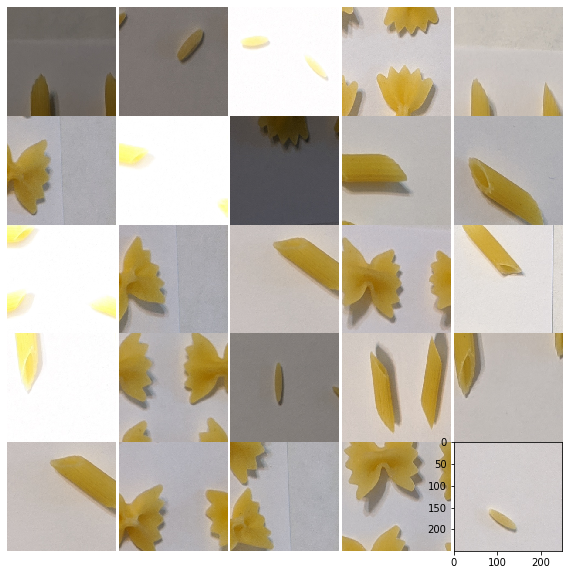

In [27]:
pasta_pics = quick_image_visualizer(new_data_path)

# Get counts of each class

In [7]:
pasta_pics[-1]

TypeError: 'NoneType' object is not subscriptable

In [28]:
# Get the number of images for each type
#farfalle_data = glob.glob('/project/data/selected_images/farfalle/**')

farfalle_data = glob.glob('/project/data/new_run/farfalle/**')


In [29]:
len(farfalle_data)

887

In [30]:
penne_data = glob.glob('/project/data/new_run/penne/**')
len(penne_data)

915

In [31]:
orzo_data = glob.glob('/project/data/new_run/orzo/**')
len(orzo_data)

460

# Feature Enineering

In [32]:
# class labels
pasta_names = {0: "farfalle",
              1: "penne",
              2: "orzo"}

# used to resize to resize
img_size = 64

num_classes = 3

# path
dir = '/project/data/new_run'


In [33]:
# load training data

X_data = []
y_data = []
for label, name in pasta_names.items():
   list_images = os.listdir(dir+'/'+name)
   for image_name in list_images:
       image = imageio.imread(dir+'/'+name+'/'+image_name)
       X_data.append(cv2.resize(image, (img_size,img_size)))
       y_data.append(label)
X_data = np.array(X_data)
y_data = np.array(y_data)

# Split data

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=42)

In [36]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [37]:

# One hot encode the labels (neural nets only like numbers)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [38]:
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")

print("-" * 10 )
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (1809, 64, 64, 3)
y_train Shape: (1809, 3)
----------
X_test Shape: (453, 64, 64, 3)
y_test Shape: (453, 3)


In [51]:
y_train[:,[0]].sum(), y_train[:,[1]].sum(), y_train[:,[2]].sum()

(700.0, 741.0, 368.0)

# Training A Simple Neural Network
### Define Your Hyperparameters
* **wandb.init()** – Initialize a new W&B run. Each run is single execution of the training script.
* **wandb.config** – Save all your hyperparameters in a config object. This lets you use W&B app to sort and compare your runs by hyperparameter values.


In [ ]:
!wandb login <MY_API_KEY>

In [41]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="pasta-tron")

W&B Run: https://app.wandb.ai/cattleman/pasta-tron/runs/1b5idoek

# Define Your Neural Network
Below, we define a simplified version of a VGG19 model in Keras, and add the following lines of code to log models metrics, visualize performance and output and track our experiments easily:

* **callbacks=[WandbCallback()]** – Fetch all layer dimensions, model parameters and log them automatically to your W&B dashboard.

In [42]:
# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = 0.001
config.epochs = 90
config.img_width=28
config.img_height=28
config.num_classes = 3
config.batch_size = 128
config.validation_size = 5000
config.weight_decay = 0.0005
config.activation = 'relu'
config.optimizer = 'nadam'
config.seed = 42

In [43]:
%%wandb
# Determine input shape
input_shape = (X_train.shape[1], X_train.shape[2], 3)

# Define the model architecture - This is a simplified version of the VGG19 architecture
model = tf.keras.models.Sequential()

# Set of Conv2D, Conv2D, MaxPooling2D layers with 32 and 64 filters
# Conv2D adds a convolution layer that generates 2 dimensional feature maps to learn different aspects of our image
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', 
                  activation ='relu', input_shape = input_shape))

# MaxPooling2D layer reduces the size of the image representation our convolutional layers learnt,
# and in doing so it reduces the number of parameters and computations the network needs to perform.
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flattens our array so we can feed the convolution layer outputs (a matrix) into our fully connected layer (an array)
model.add(tf.keras.layers.Flatten())

# Dense layer creates dense, fully connected layers with x inputs and y outputs - it simply outputs the dot product of our inputs and weights
model.add(tf.keras.layers.Dense(512, activation ='relu'))

model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

# Define the optimizer
optimizer = tf.keras.optimizers.Nadam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

# Fit the model to the training data
model.fit_generator(datagen.flow(X_train, y_train, batch_size=config.batch_size),
                    steps_per_epoch=len(X_train) / 32, epochs=config.epochs,
                    validation_data=(X_test, y_test), verbose=0,
                    callbacks=[WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=pasta_names),
                                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

wandb: Network error resolved after 0:00:25.597519, resuming normal operation.


In [48]:
WandbCallback?